In [54]:
import pathlib
import re

import numpy as np
import matplotlib.pyplot as plt
import polars as pl

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

import plotsauce.schemes as pltschemes

plt.style.use('pltstyle.mplstyle')

# Transformation in 2D

$\theta$: CCW+

Transformation matrix $[T]$

$$
m = cos(\theta),\; n = sin(\theta)
$$

$$
T = \begin{bmatrix}
m^2 & n^2 & 2mn \\
n^2 & m^2 & -2mn \\
-mn & mn & m^2 - n^2 \\
\end{bmatrix}
$$


Stress terms

$$
\begin{align*}
\sigma_{11} &= \sigma_{xx}m^2 + \sigma_{yy}n^2 + 2\sigma_{xy}mn \\
\sigma_{22} &= \sigma_{xx}n^2 + \sigma_{yy}m^2 - 2\sigma_{xy}mn \\
\sigma_{12} &= (\sigma_{yy} - \sigma_{xx})mn + \sigma_{xy}(m^2 - n^2)
\end{align*}
$$

Strain terms

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{xx}m^2 + \varepsilon_{yy}n^2 + 2\varepsilon_{xy}mn \\
\varepsilon_{22} &= \varepsilon_{xx}n^2 + \varepsilon_{yy}m^2 - 2\varepsilon_{xy}mn \\
\varepsilon_{12} &= (\varepsilon_{yy} - \varepsilon_{xx})mn + \varepsilon_{xy}(m^2 - n^2)
\end{align*}
$$

Local from global:

$$
\begin{align*}
[\varepsilon_{local}] &= [S_{local}][\sigma_{local}] \\
[T][\varepsilon_{global}] &= [S_{local}][T][\sigma_{global}]
\end{align*}
$$

# Full characterization of in-plane properties

## Assumptions

In the gage area, neglecting boundary effects, free strain in off-axis $(xx/xy)$ directions. Thus, off-axis stresses are $<< \sigma_{yy}$

- $\sigma_{xx} \approx 0$
- $\sigma_{xy} \approx 0$

Furthermore, measurement of strains in the pulling direction $\varepsilon_{yy}$ and transverse direction $\varepsilon_{xx}$ are expected to be known from the test data.

## $E_{11}$ and $\nu_{12}$

$\theta = 90^{\circ} \rightarrow m = 0,\; n = 1$

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{yy} \\
\varepsilon_{22} &= \varepsilon_{xx} \\
\sigma_{11} &= \sigma_{yy} \\
\sigma_{22} &= \sigma_{xx} = 0 \\
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{11} &= 1/E_{11}*\sigma_{11} - \nu_{12}/E_{11}*\sigma_{22} \\
\varepsilon_{yy} &= 1/E_{11}*\sigma_{yy} - \nu_{12}/E_{11}*\sigma_{xx} \\
\varepsilon_{yy} &= 1/E_{11}*\sigma_{yy} \\
\end{align*}
$$

$$
\therefore E_{11} = \frac{\sigma_{yy}}{\varepsilon_{yy}}
$$

$$
\begin{align*}
\nu_{12} &= -\varepsilon_{22}/\varepsilon_{11}
&= -\varepsilon_{yy}/\varepsilon_{xx}
\end{align*}
$$


$$
\therefore \nu_{12} = \frac{-\varepsilon_{yy}}{\varepsilon_{xx}}
$$

## $E_{22}$

$\theta = 0^{\circ} \rightarrow n = 0,\; m = 1$

$$
\begin{align*}
\varepsilon_{11} &= \varepsilon_{xx} \\
\varepsilon_{22} &= \varepsilon_{yy} \\
\sigma_{11} &= \sigma_{xx} = 0 \\
\sigma_{22} &= \sigma_{yy} \\
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{22} &= -\nu_{12}/E_{11}*\sigma_{11} + 1/E_{22}*\sigma_{22} \\
\varepsilon_{yy} &= -\nu_{12}/E_{11}*\sigma_{xx} + 1/E_{22}*\sigma_{yy} \\
\varepsilon_{yy} &= 1/E_{22}*\sigma_{yy} \\
\end{align*}
$$

$$
\therefore E_{22} = \frac{\sigma_{yy}}{\varepsilon_{yy}}
$$

## $G_{12}$

$\theta = 45^{\circ} \rightarrow m = n = \frac{\sqrt{2}}{2}$

$$
\begin{align*}
\varepsilon_{12} &= (\varepsilon_{yy} - \varepsilon_{xx})mn = \frac{1}{2}(\varepsilon_{yy} - \varepsilon_{xx}) \\
\sigma_{12} &= (\sigma_{yy} - \sigma_{xx})mn = \frac{1}{2}\sigma_{yy}
\end{align*}
$$

$$
\begin{align*}
\varepsilon_{12} &= \frac{1}{G_{12}}\sigma_{12} \\
\frac{1}{2}(\varepsilon_{yy} - \varepsilon_{xx}) &= \frac{1}{G_{12}}\frac{1}{2}\sigma{yy} \\
\end{align*}
$$

$$
\therefore G_{12} = \frac{\sigma_{yy}}{\varepsilon_{yy} - \varepsilon_{xx}}
$$


# Convergence study

In [55]:
JOB_DIRS = {
    'linear': pathlib.Path('./jobs/linear'),
}
KNOWN_PROPS = {
    'E11': 231000,
    'E22': 15000,
    'nu12': 0.21,
    'G12': 15800, 
}

In [56]:
def get_stats_by_angle(job_id: str, job_dir: pathlib.Path) -> pl.DataFrame:
    stats = []
    for fp in job_dir:
        if not fp.is_dir(): continue
        job_name = fp.stem
        if job_id not in job_name: continue
        
        # Load simulation data
        # G = np.load(fp.joinpath('gage_.npy'))
        Q = np.load(fp.joinpath('nodal_disp.npy'))
        F = np.load(fp.joinpath('nodal_reaction_force.npy'))
        gage_stress = np.load(fp.joinpath('gage_stress.npy'))
        gage_strain = np.load(fp.joinpath('gage_strain.npy'))
        gage_stress_glob = np.load(fp.joinpath('gage_stress_glob.npy'))
        gage_strain_glob = np.load(fp.joinpath('gage_strain_glob.npy'))
        
        # Load summary info
        with open(fp.joinpath('job_summary.log'), 'r') as f:
            summary = {}
            for line in f.readlines():
                k, v = line.split(": ")
                summary.update({k: v.strip()}) 

        # Compute mean props
        stats.append({
            'elements': summary['Elements'], 
            'nodes': summary['Nodes'],
            'gage_stress': np.mean(gage_stress, axis=(0, 1)),
            'gage_strain': np.mean(gage_strain, axis=(0, 1)),
            'gage_stress_glob': np.mean(gage_stress_glob, axis=(0, 1)),
            'gage_strain_glob': np.mean(gage_strain_glob, axis=(0, 1)),
            'disp': Q,
            'force': F,
            'disp_1': np.mean(Q[0::2]),
            'disp_2': np.mean(Q[1::2]),
            'react_1': np.mean(F[0::2]),
            'react_2': np.mean(F[1::2]),
            'theta': re.search(r'_(\d+)', job_name).group(1)
        })

    # Convert to dataframe and compute percent change
    df = pl.DataFrame(
    {
        'elements': [int(s['elements']) for s in stats],
        'S11': [s['gage_stress'][0][0] for s in stats],
        'S22': [s['gage_stress'][1][0] for s in stats],
        'S12': [s['gage_stress'][2][0] for s in stats],
        'E11': [s['gage_strain'][0][0] for s in stats],
        'E22': [s['gage_strain'][1][0] for s in stats],
        'E12': [s['gage_strain'][2][0] for s in stats],
        'SXX': [s['gage_stress_glob'][0][0] for s in stats],
        'SYY': [s['gage_stress_glob'][1][0] for s in stats],
        'SXY': [s['gage_stress_glob'][2][0] for s in stats],
        'EXX': [s['gage_strain_glob'][0][0] for s in stats],
        'EYY': [s['gage_strain_glob'][1][0] for s in stats],
        'EXY': [s['gage_strain_glob'][2][0] for s in stats],
        'react_1': [s['disp_1'] for s in stats],
        'disp_2': [s['disp_2'] for s in stats],
        'react_1': [s['react_1'] for s in stats],
        'react_2': [s['react_2'] for s in stats],
    })
    return df.with_columns(pl.all().pct_change().abs().name.suffix('_pct'))

In [76]:
dfs = {0: get_stats_by_angle('_0', JOB_DIRS['linear'].glob('*')), 90: get_stats_by_angle('_90', JOB_DIRS['linear'].glob('*')), 45: get_stats_by_angle('_45', JOB_DIRS['linear'].glob('*'))}
print(dfs[45].select('S11'))

shape: (6, 1)
┌────────────┐
│ SYY        │
│ ---        │
│ f64        │
╞════════════╡
│ 122.094056 │
│ 110.942496 │
│ 110.419006 │
│ 110.564068 │
│ 110.624226 │
│ 110.638408 │
└────────────┘


## $\theta = 90$

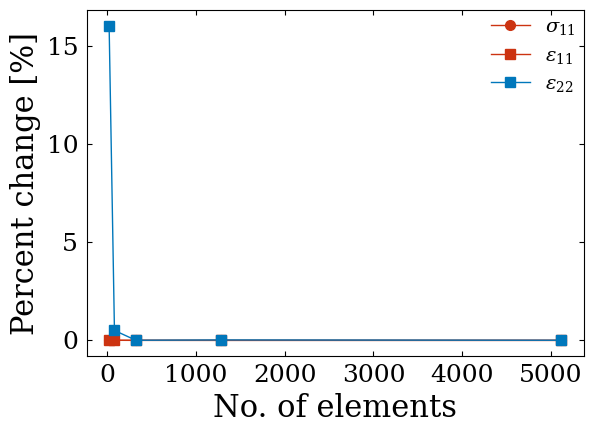

In [58]:
fig, ax = plt.subplots()
ax.plot(dfs[90].select('elements'), dfs[90].select('S11_pct')*100, label=r'$\sigma_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(dfs[90].select('elements'), dfs[90].select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='s', linestyle='-', linewidth=1.0)
ax.plot(dfs[90].select('elements'), dfs[90].select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.BLUE.value, marker='s', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'Percent change [%]')
ax.legend()
fig.tight_layout()
fig.savefig('theta_0_convergence.svg')

## $\theta = 0$

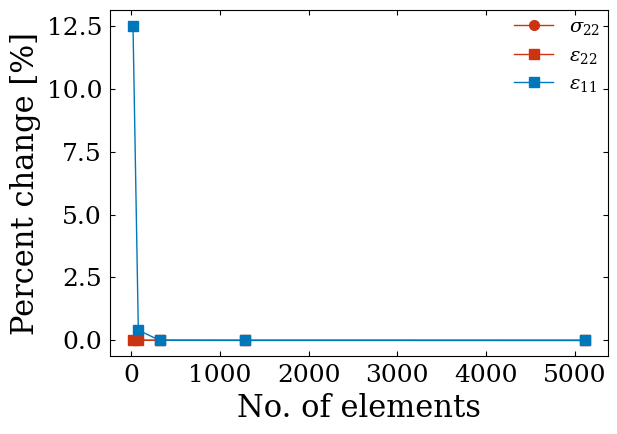

In [59]:
fig, ax = plt.subplots()
ax.plot(dfs[0].select('elements'), dfs[0].select('S22_pct')*100, label=r'$\sigma_{22}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(dfs[0].select('elements'), dfs[0].select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.RED.value, marker='s', linestyle='-', linewidth=1.0)
ax.plot(dfs[0].select('elements'), dfs[0].select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.BLUE.value, marker='s', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'Percent change [%]')
ax.legend()
fig.tight_layout()
fig.savefig('theta_90_convergence.svg')

## $\theta = 45$

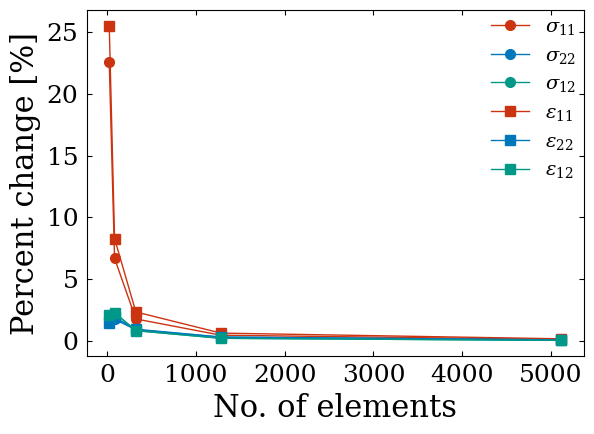

In [60]:
fig, ax = plt.subplots()
ax.plot(dfs[45].select('elements'), dfs[45].select('S11_pct')*100, label=r'$\sigma_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(dfs[45].select('elements'), dfs[45].select('S22_pct')*100, label=r'$\sigma_{22}$', color=pltschemes.VibrantScheme.BLUE.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(dfs[45].select('elements'), dfs[45].select('S12_pct')*100, label=r'$\sigma_{12}$', color=pltschemes.VibrantScheme.TEAL.value, marker='o', linestyle='-', linewidth=1.0)
ax.plot(dfs[45].select('elements'), dfs[45].select('E11_pct')*100, label=r'$\varepsilon_{11}$', color=pltschemes.VibrantScheme.RED.value, marker='s', linestyle='-', linewidth=1.0)
ax.plot(dfs[45].select('elements'), dfs[45].select('E22_pct')*100, label=r'$\varepsilon_{22}$', color=pltschemes.VibrantScheme.BLUE.value, marker='s', linestyle='-', linewidth=1.0)
ax.plot(dfs[45].select('elements'), dfs[45].select('E12_pct')*100, label=r'$\varepsilon_{12}$', color=pltschemes.VibrantScheme.TEAL.value, marker='s', linestyle='-', linewidth=1.0)
ax.set_xlabel('No. of elements')
ax.set_ylabel(r'Percent change [%]')
ax.legend()
fig.tight_layout()
fig.savefig('theta_45_convergence.svg')

# Characterization

In [61]:
def compute_props(df_0: pl.DataFrame, df_90: pl.DataFrame, df_45: pl.DataFrame, nelems: int) -> dict[str, float]:
    E11 = df_90.filter(elements=nelems).select('SYY')/df_90.filter(elements=nelems).select('EYY')
    E22 = df_0.filter(elements=nelems).select('SYY')/df_0.filter(elements=nelems).select('EYY')
    nu12 = -1*df_90.filter(elements=nelems).select('EXX')/df_90.filter(elements=nelems).select('EYY') 
    G12 = df_45.filter(elements=nelems).select('SYY')/(2*(df_45.filter(elements=nelems).select('EYY') - df_45.filter(elements=nelems).select('EXX')))
    return {
        'E11': E11.item(),
        'E22': E22.item(),
        'nu12': nu12.item(),
        'G12': G12.item()
    }

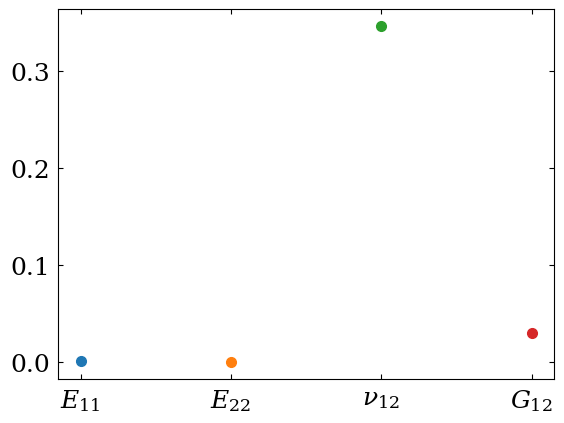

In [62]:
char = compute_props(dfs[0], dfs[90], dfs[45], 1280)
fig, ax = plt.subplots()
ax.plot(r'$E_{11}$', 100*abs(char['E11'] - KNOWN_PROPS['E11'])/KNOWN_PROPS['E11'], marker='o')
ax.plot(r'$E_{22}$', 100*abs(char['E22'] - KNOWN_PROPS['E22'])/KNOWN_PROPS['E22'], marker='o')
ax.plot(r'$\nu_{12}$', 100*abs(char['nu12'] - KNOWN_PROPS['nu12'])/KNOWN_PROPS['nu12'], marker='o')
ax.plot(r'$G_{12}$', 100*abs(char['G12'] - KNOWN_PROPS['G12'])/KNOWN_PROPS['G12'], marker='o')
# ax.set_ylim(0.95, 1.05)

## Sensitivity

In [71]:
df = pl.read_csv('sensitivity_study_results.csv')
df = df.filter(p=0.01).sort(by='elements')

shape: (6, 1)
┌────────────┐
│ S11        │
│ ---        │
│ f64        │
╞════════════╡
│ 119.276795 │
│ 92.391746  │
│ 86.211423  │
│ 84.671223  │
│ 84.272558  │
│ 84.16286   │
└────────────┘


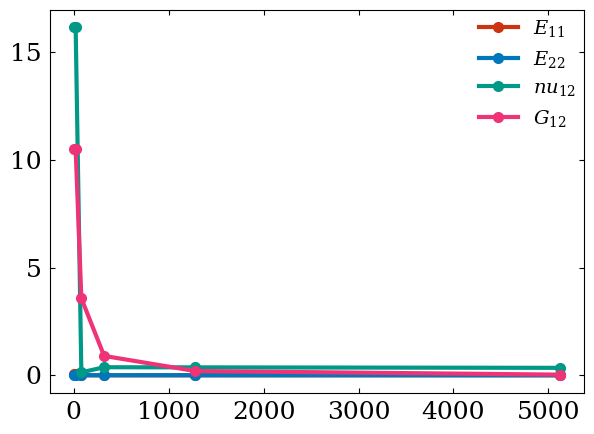

In [69]:
fig, ax = plt.subplots()
ax.plot(df.select('elements'), df.select('E11_tol'), marker='o', linestyle='-', color=pltschemes.VibrantScheme.RED.value, label=r'$E_{11}$')
ax.plot(df.select('elements'), df.select('E22_tol'), marker='o', linestyle='-', color=pltschemes.VibrantScheme.BLUE.value, label=r'$E_{22}$')
ax.plot(df.select('elements'), df.select('nu12_tol'), marker='o', linestyle='-', color=pltschemes.VibrantScheme.TEAL.value, label=r'$nu_{12}$')
ax.plot(df.select('elements'), df.select('G12_tol'), marker='o', linestyle='-', color=pltschemes.VibrantScheme.MAGENTA.value, label=r'$G_{12}$')
ax.legend()
fig.tight_layout()
fig.savefig('sensitivity_study.svg')

In [65]:
JOB_DIRS = {
    'linear': pathlib.Path('./jobs/linear'),
}

theta_data = {}
for fp in JOB_DIRS['linear'].glob('*mesh5*'):
    if not fp.is_dir(): continue
    job_name = fp.stem
    
    # Load simulation data
    # G = np.load(fp.joinpath('gage_.npy'))
    # Q = np.load(fp.joinpath('displacements.npy'))
    # F = np.load(fp.joinpath('reaction_forces.npy'))
    gage_stress = np.load(fp.joinpath('gage_stress_glob.npy'))
    gage_strain = np.load(fp.joinpath('gage_strain_glob.npy'))
    
    # Load summary info
    with open(fp.joinpath('job_summary.log'), 'r') as f:
        summary = {}
        for line in f.readlines():
            k, v = line.split(": ")
            summary.update({k: v.strip()}) 

    # Compute mean props
    theta = int(re.search(r'_(\d+)', job_name).group(1))
    theta_data.update({theta: 
        {
            'elements': summary['Elements'], 
            'nodes': summary['Nodes'],
            'gage_stress': np.mean(gage_stress, axis=(0, 1)),
            'gage_strain': np.mean(gage_strain, axis=(0, 1)),
            # 'disp': np.mean(Q, axis=(0, 1)),
            # 'react': np.mean(F, axis=(0, 1)),
        }
    })

In [66]:
theta = 45
m = np.cos(np.deg2rad(theta))
n = np.sin(np.deg2rad(theta))
sigma_yy = theta_data[theta]['gage_stress'][1][0]
eps_yy = theta_data[theta]['gage_strain'][1][0]
E11 = 231000
E22 = 15000
G12 = 15800

K = np.array([
    [m**2, 2*m*n, (sigma_yy/E11)*m**2],
    [n**2, -2*m*n, (sigma_yy/E11)*n**2],
    [-m*n, (m**2 - n**2), 0],
])
F = np.array([
    [((1/E11)*sigma_yy - eps_yy)*n**2],
    [((1/E22)*sigma_yy - eps_yy)*m**2],
    [((1/G12)*sigma_yy - eps_yy)*m*n],
])
test = np.matmul(np.linalg.inv(K), F)
print(test)
print(theta_data[theta]['gage_strain'])
print(theta_data[theta]['gage_stress'])

[[-4.90836185e-03]
 [-2.43812386e-03]
 [ 8.07458279e+00]]
[[ 4.39517454e-05]
 [ 4.99330149e-03]
 [-4.43893079e-03]]
[[4.68289345e-02]
 [1.56446281e+02]
 [6.02600346e+00]]
